In [1]:
import pandas
from datetime import datetime
from scipy import stats
import calendar
import numpy

In [2]:
data = None
filtered_data = None
regions = None
divided_by_days = None

##### Загружаем данные

In [3]:
def read_data(date):
    data = pandas.read_csv('./raw_data/yellow_tripdata_' + date + '.csv')
    return data

In [4]:
#data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
#data['tpep_dropoff_datetime'] = data['tpep_dropoff_datetime'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
#data.head()

##### Функция фильтрации данных

Удаляем поездки, которые закончились раньше, чем начались, поездки без пассажиров, с нулевым расстоянием, поездки вне Нью-Йорка.

Также определяем регион для каждой поездки в соответствии с фалом regions.csv. Во времени начала поездки оставляем только интересующие нас данные: дату и час.

In [5]:
def filter_data(data, regions):
    filtered_data = data[
        (data['tpep_pickup_datetime'] < data['tpep_dropoff_datetime']) &
        (data['passenger_count'] > 0) &
        (data['trip_distance'] > 0) &
        (data['pickup_longitude'] > -74.25559) &
        (data['pickup_longitude'] < -73.70001) &
        (data['pickup_latitude'] > 40.49612) &
        (data['pickup_latitude'] < 40.91553)
    ]
    
    x_edges = regions[['west', 'east']].stack().unique()
    y_edges = regions[['south', 'north']].stack().unique()
    
    loc_bins = stats.binned_statistic_2d(
        filtered_data['pickup_longitude'],
        filtered_data['pickup_latitude'], 
        None, 
        statistic='count', 
        bins=[x_edges, y_edges],
        expand_binnumbers=True
    )
    
    filtered_data['region'] = map(lambda x: (x[0]-1) * 50 + x[1], zip(loc_bins.binnumber[0], loc_bins.binnumber[1]))
    filtered_data['tpep_pickup_datetime'] = filtered_data['tpep_pickup_datetime'].apply(lambda d: d[0:-6])
    filtered_data['day'] = filtered_data['tpep_pickup_datetime'].apply(lambda d: d[0:-3])
    
    return filtered_data

In [6]:
def get_year_month(date):
    return int(date[0:4]), int(date[5:len(date)])

In [7]:
def get_date_number(number):
    string = str(number)
    if len(string) == 2:
        return string
    else:
        return '0' + string

##### Получаем временной ряд

Для ускорения работы разбиваем данные по дням. Для каждого дня получаем временной ряд. Все временные ряды собираем в один DataFrame 'time_seris' и сохраняем в файл для дальнейшего использования.

In [8]:
def get_time_series_for_day(date, data, regions):
    timestamp = []
    for h in range(0, 24):
        timestamp.append(date + '-' + data['day'][data.index[0]][-2: len(data['day'])] + ' ' + get_date_number(h))
    
    region_array = numpy.tile(regions.index + 1, len(timestamp))
    timestamp_array = numpy.repeat(timestamp, len(regions))
    time_series = pandas.DataFrame({'timestamp': timestamp_array, 'region': region_array, 'value': numpy.zeros(len(region_array))})
    
    data_copy = data.copy()
    while data_copy.shape[0] > 0:
        #print data_copy.shape[0]
        t = data_copy['tpep_pickup_datetime'][data_copy.index[0]]
        r = data_copy['region'][data_copy.index[0]]
        count_before = data_copy.shape[0]
        data_copy = data_copy.drop(data_copy.index[
            (data_copy['tpep_pickup_datetime'] == t) & 
            (data_copy['region'] == r)
        ])
        value = count_before - data_copy.shape[0]
        
        index = time_series.index[
            (time_series['timestamp'] == t) &
            (time_series['region'] == r)
        ][0]
        time_series['value'][index] = value
    
    return time_series

In [57]:
def get_time_series(date, data, filtered_data, regions, divided_by_days):
    if data is None:
        data = read_data(date)
    print 'Data read', data.shape
    if regions is None:
        regions = pandas.read_csv('./raw_data/regions.csv', delimiter=';');
    print 'Regions read', regions.shape
    if filtered_data is None:
        filtered_data = filter_data(data, regions)
    print 'Data filtered', filtered_data.shape
    
    if divided_by_days is None:
        unique_days = filtered_data['day'].unique()
        divided_by_days = []
        for d in unique_days:
            divided_by_days.append(filtered_data[filtered_data['day'] == d])
    print 'Days: ', len(divided_by_days)
    
    time_series = pandas.DataFrame(columns=['timestamp', 'region', 'value'])
    count = len(divided_by_days)
    for d in divided_by_days:
        time_series = time_series.append(get_time_series_for_day(date, d, regions))
        count -= 1
        print 'Day', d['day'][d.index[0]], 'finished', d.shape, count, 'left'
        
    time_series.to_csv('./time_series/' + date + '.csv')
    return time_series, data, filtered_data, regions, divided_by_days

In [10]:
%%time
time_series, data, filtered_data, regions, divided_by_days = get_time_series('2016-05', data, filtered_data, regions, divided_by_days)

Data read (11836853, 19)
Regions read (2500, 5)


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Data filtered (11626521, 21)
Days:  31


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Day 2016-05-01 finished (375250, 21) 30 left
Day 2016-05-04 finished (400400, 21) 29 left
Day 2016-05-05 finished (417113, 21) 28 left
Day 2016-05-02 finished (351456, 21) 27 left
Day 2016-05-03 finished (393754, 21) 26 left
Day 2016-05-06 finished (429070, 21) 25 left
Day 2016-05-07 finished (426262, 21) 24 left
Day 2016-05-08 finished (366631, 21) 23 left
Day 2016-05-09 finished (342943, 21) 22 left
Day 2016-05-10 finished (368750, 21) 21 left
Day 2016-05-11 finished (376328, 21) 20 left
Day 2016-05-12 finished (393014, 21) 19 left
Day 2016-05-13 finished (389878, 21) 18 left
Day 2016-05-14 finished (428305, 21) 17 left
Day 2016-05-15 finished (400366, 21) 16 left
Day 2016-05-16 finished (371422, 21) 15 left
Day 2016-05-18 finished (373996, 21) 14 left
Day 2016-05-22 finished (362725, 21) 13 left
Day 2016-05-20 finished (406896, 21) 12 left
Day 2016-05-25 finished (379594, 21) 11 left
Day 2016-05-17 finished (389920, 21) 10 left
Day 2016-05-19 finished (398731, 21) 9 left
Day 2016-05

Полученный DataFrame содержит время, регион и количество поездок для данного региона за данный час.

In [56]:
ts = pandas.read_csv('./time_series/2016-05.csv')
ts.head()

,Unnamed: 0,region,timestamp,value
0,0,1,2016-05-01 00,0.0
1,1,2,2016-05-01 00,0.0
2,2,3,2016-05-01 00,0.0
3,3,4,2016-05-01 00,0.0
4,4,5,2016-05-01 00,0.0


##### Получаем временной ряд для Empire State Building

In [28]:
regions = pandas.read_csv('./raw_data/regions.csv', delimiter=';');
ebs_coords = (-73.985656, 40.748433)
ebs_region = regions[
    (regions['west'] < ebs_coords[0]) &
    (regions['east'] > ebs_coords[0]) &
    (regions['south'] < ebs_coords[1]) &
    (regions['north'] > ebs_coords[1])
]
ebs_index = ebs_region['region'][ebs_region.index[0]]
ebs_index

1231

In [36]:
ebs_ts = ts[ts['region'] == ebs_index].sort_values(by='timestamp', ascending=True)
print ebs_ts.shape
ebs_ts.head()

(744, 4)


,Unnamed: 0,region,timestamp,value
1230,1230,1231,2016-05-01 00,881.0
3730,3730,1231,2016-05-01 01,713.0
6230,6230,1231,2016-05-01 02,533.0
8730,8730,1231,2016-05-01 03,418.0
11230,11230,1231,2016-05-01 04,353.0


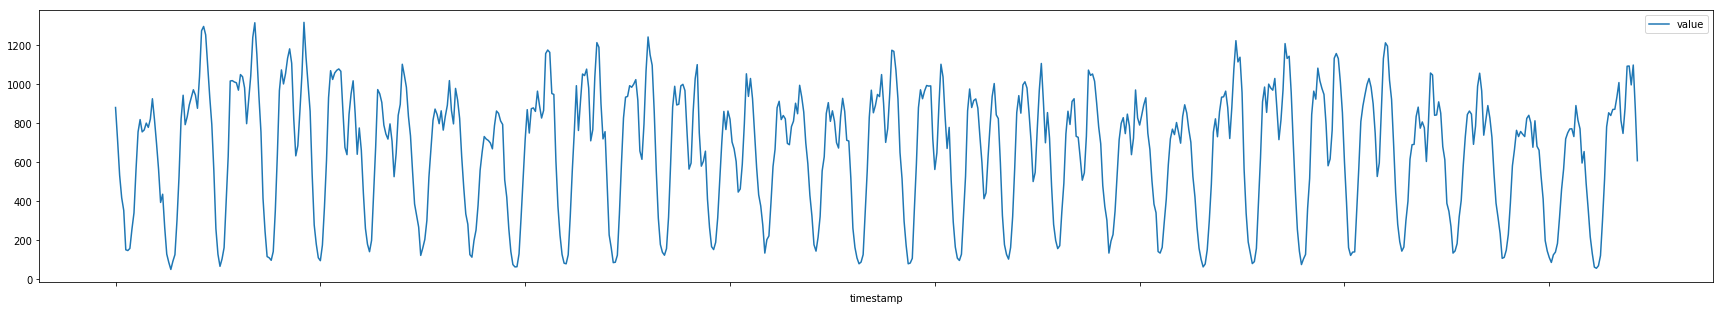

In [45]:
ebs_ts.plot(x='timestamp', y='value', figsize=(30,5))

На графике довольно хорошо выражена дневная сезонность

Количество пар час - регион, для которых не было ни одной поездки.

In [58]:
print ts[ts['value'] == 0].shape[0]

1718238
